In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
import os
import collections
from tqdm import tqdm
HERE = %pwd
sys.path.append(os.path.dirname(HERE))

%matplotlib inline
import matplotlib.pyplot as plt
import copy

import pickle
import time

In [2]:
# functions
from src import utils, main, post_process

In [3]:
# preprocessed directory
version_infer = "20250418_infer"
version_input = "20250403_input"
version_prep = "20250403_prep"
n_user = 200  

n_user_exp = 10

# LLM names
d_model = {
    #"phi4" : "phi4",
    #"nova-lite-v1" : "amazon-nova-lite",
    #"gpt-4o-mini-2024-07-18" : "gpt-4o-mini", 
    "llama3-3-70b-instruct-v1" : "llama3.3-70b", 
    "gpt-4.1-mini-2025-04-14" : "gpt-4.1-mini",
    "claude-3-5-haiku-20241022-v1" : "claude-3.5-haiku",
    "gpt-4.1-2025-04-14" : "gpt-4.1",
    "claude-3-7-sonnet-20250219-v1" : "claude-3.7-sonnet",
    "o3-mini-2025-01-31" : "o3-mini",
    "o4-mini-2025-04-16" : "o4-mini",
    "claude-3-7-sonnet-20250219-v1_Thinking" : "claude-3.7-sonnet (T)",
    "o3-2025-04-16" : "o3"    
}
model_names = list(d_model.keys())
model_names_short = list(d_model.values())

# data names
data_names = ["Yelp", "MIND", "Food"] + [f"Amazon_{a}" for a in ["Movie", "Music", "Grocery", "Clothes", "Book"]]

# prompt names
L = ["Rephrase", "StepBack", "ReAct"]

types_prompt = [
    f"ItemAll_Method{b}" for b in ["Baseline"] + L
]

# user types
exp_names = ["light", "heavy"]

# nDCG@k, Hit@k
k = 3

# set random seed
utils.set_seed()

In [4]:
# load computed data if exists; run otherwise
ds = dict()
dc = dict()

for model_name, model_name_short in d_model.items():
    print(model_name)
    llm = utils.load_llm(model_name)
    
    dict_res, df_cost = main.run(
        llm=llm, data_names=data_names, types_prompt=types_prompt, exp_names=exp_names, k=k,
        model_name=model_name, version_infer=version_infer, 
        n_user=n_user, version_input=version_input, version_prep=version_prep, n_user_exp=n_user_exp
    )

    ds[model_name_short] = dict_res
    dc[model_name_short] = df_cost

llama3-3-70b-instruct-v1


100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.58it/s]


finished
gpt-4.1-mini-2025-04-14


100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.79it/s]


finished
claude-3-5-haiku-20241022-v1


100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.78it/s]


finished
gpt-4.1-2025-04-14


100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.54it/s]


finished
claude-3-7-sonnet-20250219-v1


100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.00it/s]


finished
o3-mini-2025-01-31


100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 10.29it/s]


finished
o4-mini-2025-04-16


100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 34.17it/s]


finished
claude-3-7-sonnet-20250219-v1_Thinking


100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 35.47it/s]


finished
o3-2025-04-16


100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 17.80it/s]

finished


In [5]:
# cost
df_cost_all = pd.DataFrame({model_name : df.loc["fee"] for model_name, df in dc.items()})
df_cost = df_cost_all.drop("sum").fillna(0)
df_cost_tex = df_cost_all.drop("sum").fillna(0).map(lambda s : f"{s:.2f}")
df_cost_all.T

,Baseline,ReAct,Rephrase,Step-Back,sum
llama3.3-70b,0.775578,1.779980,1.741889,1.685555,5.983001
gpt-4.1-mini,0.427915,1.179428,1.147890,1.076596,3.831829
claude-3.5-haiku,1.025650,2.409483,2.281179,2.301313,8.017625
gpt-4.1,2.130438,5.757508,4.887930,4.870310,17.646186
claude-3.7-sonnet,3.852048,10.688871,9.228276,8.712426,32.481621
o3-mini,2.790153,NaN,5.004489,4.820917,12.615559
o4-mini,2.088067,NaN,NaN,NaN,2.088067
claude-3.7-sonnet (T),7.719978,NaN,NaN,NaN,7.719978
o3,11.362124,NaN,NaN,NaN,11.362124


In [6]:
# select mode
# - "latex" will give all table info in latex format
# - "view" will give all table info in pandas dataframe html style
presentation = ["latex", "view"][1]

# Section 5.2
## Table 13

In [7]:
# nDCG@3 by all model
metric = "nDCG"
k = 3
d_ = dict()
for model_name in model_names_short:
    dict_res = ds[model_name]
    df_res = pd.concat(dict_res[f"{metric}@{k}"].values())
    
    df = post_process.convert_stat_table_with_latex(df_res, l_select=[])
    df_ = df[["tex", "score"]]
    d_[model_name] = df_

df_model = pd.DataFrame({model_name : df_["score"] for model_name, df_ in d_.items()})
df_model_tex = pd.DataFrame({model_name : df_["tex"] for model_name, df_ in d_.items()}).fillna("")

# add accuracy with cost
d_ = dict()
d_tex = dict()
for model_name in model_names_short:
    df = pd.concat([df_model[model_name], df_cost[model_name]], axis=1)
    df.columns = ["score", "cost"]
    d_[model_name] = df

    df = pd.concat([df_model_tex[model_name], df_cost_tex[model_name]], axis=1)
    df.columns = ["score", "cost"]
    d_tex[model_name] = df
df = pd.concat({k : v.T.apply(lambda s : f"{s.iloc[0]} / {s.iloc[1]}") for k,v in d_tex.items()}, axis=1).T


def _tmp(s):
    if len(set(s.split("/")[0])) == 1:
        s = "-"
    return s
    
df = df.map(_tmp)
df = df[['Baseline', 'Rephrase', 'Step-Back', 'ReAct']]
if presentation == "latex":
    print(df.to_latex(escape=False))
else:
    def _tmp(s):
        try:
            s = f"{s:.3f}"
        except:
            s = ""
        return s
        
        
    df = df_model.T.map(_tmp) + " / " + df_cost_all.drop("sum").T.map(_tmp)
    df = df[['Baseline', 'Rephrase', 'Step-Back', 'ReAct']]
    display(df)

,Baseline,Rephrase,Step-Back,ReAct
llama3.3-70b,0.465 / 0.776,0.548 / 1.742,0.543 / 1.686,0.533 / 1.780
gpt-4.1-mini,0.475 / 0.428,0.550 / 1.148,0.516 / 1.077,0.547 / 1.179
claude-3.5-haiku,0.516 / 1.026,0.501 / 2.281,0.506 / 2.301,0.516 / 2.409
gpt-4.1,0.526 / 2.130,0.515 / 4.888,0.527 / 4.870,0.561 / 5.758
claude-3.7-sonnet,0.621 / 3.852,0.621 / 9.228,0.628 / 8.712,0.609 / 10.689
o3-mini,0.552 / 2.790,0.537 / 5.004,0.542 / 4.821,nan / nan
o4-mini,0.537 / 2.088,nan / nan,nan / nan,nan / nan
claude-3.7-sonnet (T),0.555 / 7.720,nan / nan,nan / nan,nan / nan
o3,0.612 / 11.362,nan / nan,nan / nan,nan / nan


## Figure 3

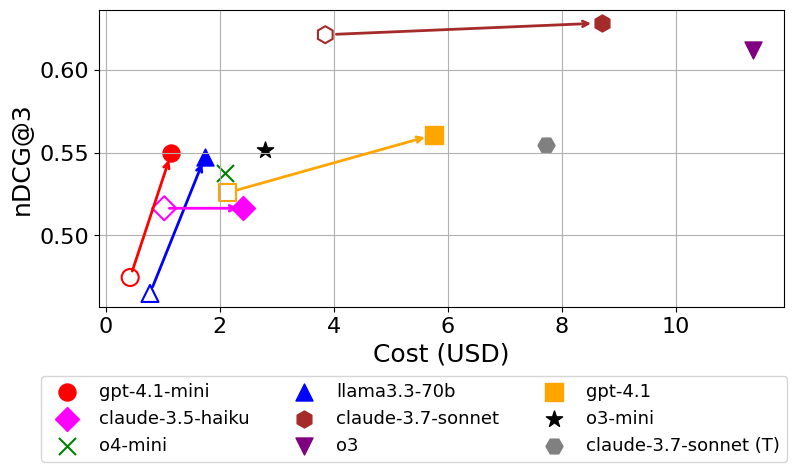

In [8]:
# accuracy-cost 2-dim plot
import pandas as pd
import matplotlib.pyplot as plt

# convert long table
df = pd.concat(d_).reset_index().rename(
    columns={"level_0" : "LLM", "level_1" : "prompt"}
).dropna()
df_ = df[(df["LLM"] == "o3-mini") * (df["prompt"] == "Baseline")]
df = df[df["LLM"] != "o3-mini"]
df = pd.concat([df, df_])

filtered_df = pd.DataFrame()
for llm in df['LLM'].unique():
    subset = df[df['LLM'] == llm]
    baseline = subset[subset['prompt'] == 'Baseline']
    max_score = subset[subset['prompt'] != 'Baseline']

    if not baseline.empty:
        baseline_row = baseline.iloc[0]
        filtered_df = pd.concat([filtered_df, baseline_row.to_frame().T])
        
    if not max_score.empty:
        max_row = max_score.loc[max_score['score'].idxmax()]
        filtered_df = pd.concat([filtered_df, max_row.to_frame().T])

marker_styles = {
    'claude-3.5-haiku': ('D', 'magenta'),
    'gpt-4.1-mini': ('o', 'red'),
    'gpt-4.1': ('s', 'orange'),
    'llama3.3-70b': ('^', 'blue'),
    'claude-3.7-sonnet': ('h', 'brown'),
    'o3-mini': ('*', 'black'),
    'o4-mini': ('x', 'green'),
    'o3': ('v', 'purple'),
    'claude-3.7-sonnet (T)': ('H', 'grey')
}

llm_with_arrows = [
    'gpt-4.1-mini', 'llama3.3-70b',
    'claude-3.5-haiku', 'gpt-4.1', 'claude-3.7-sonnet'
]

plt.figure(figsize=(8.4, 5))
handled_labels = set()
for llm in filtered_df['LLM'].unique():
    df_llm = filtered_df[filtered_df['LLM'] == llm]
    marker_shape, color = marker_styles.get(llm, ('o', 'black'))

    baseline_row = df_llm[df_llm['prompt'] == 'Baseline']
    max_row = df_llm[df_llm['prompt'] != 'Baseline']

    if not baseline_row.empty:
        baseline_row = baseline_row.iloc[0]
        for _, row in df_llm.iterrows():
            if llm in llm_with_arrows:
                if row['prompt'] != 'Baseline': 
                    plt.scatter(
                        row['cost'], row['score'], marker=marker_shape, color=color, s=150, label=f"{llm}"
                    )
                else: 
                    plt.scatter(
                        row['cost'], row['score'], marker=marker_shape, edgecolors=color, facecolors='none', s=150, linewidths=1.5, label=""
                    )
            else:  # reasoning model 
                plt.scatter(row['cost'], row['score'], marker=marker_shape, color=color, s=150, label=f"{llm}")

    if not max_row.empty and llm in llm_with_arrows:
        max_row = max_row.loc[max_row['score'].idxmax()]

        x1 = baseline_row['cost']
        y1 = baseline_row['score']

        x2 = max_row['cost']
        y2 = max_row['score']

        dx = (x2 - x1) * 0.03
        dy = (y2 - y1) * 0.03
        
        plt.annotate(
            '', xy=(x2-dx, y2-dy), xytext=(x1+dx, y1+dy), arrowprops=dict(facecolor=color, edgecolor=color, arrowstyle='->', linewidth=2)
        )

        

plt.tick_params('x', labelsize=16)
plt.tick_params('y', labelsize=16)
plt.xlabel('Cost (USD)', fontsize=18)
plt.ylabel('nDCG@3', fontsize=18)
plt.grid(True)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

ordered_keys = [
    'gpt-4.1-mini',
    'claude-3.5-haiku',
    'o4-mini',
    'llama3.3-70b',
    'claude-3.7-sonnet',
    'o3',
    'gpt-4.1',
    'o3-mini',
    'claude-3.7-sonnet (T)'
]

ordered_handles = [by_label[key] for key in ordered_keys]

plt.legend(ordered_handles, ordered_keys, loc='upper center', bbox_to_anchor=(0.46, -0.2), ncol=3, fontsize=13)

plt.tight_layout()
plt.savefig("cost_map_high.png", transparent=True, bbox_inches='tight')
plt.show()

## Supplementary material (Table 16)

In [9]:
# nDCG@3 by all model
metric = "Hit"
k = 3
d_ = dict()
for model_name in model_names_short:
    dict_res = ds[model_name]
    df_res = pd.concat(dict_res[f"{metric}@{k}"].values())
    
    df = post_process.convert_stat_table_with_latex(df_res, l_select=[])
    df_ = df[["tex", "score"]]
    d_[model_name] = df_

df_model = pd.DataFrame({model_name : df_["score"] for model_name, df_ in d_.items()})
df_model_tex = pd.DataFrame({model_name : df_["tex"] for model_name, df_ in d_.items()}).fillna("")


if presentation == "latex":
    df = df_model_tex.copy().T
    df = df[['Baseline', 'Rephrase', 'Step-Back', 'ReAct']]
    print(df.to_latex(escape=False))
else:
    def _tmp(s):
        try:
            s = f"{s:.3f}"
        except:
            s = ""
        return s
        
        
    df = df_model.T.map(_tmp)
    df = df[['Baseline', 'Rephrase', 'Step-Back', 'ReAct']]
    display(df)

,Baseline,Rephrase,Step-Back,ReAct
llama3.3-70b,0.537,0.650,0.656,0.644
gpt-4.1-mini,0.581,0.662,0.619,0.650
claude-3.5-haiku,0.606,0.613,0.600,0.625
gpt-4.1,0.619,0.606,0.606,0.644
claude-3.7-sonnet,0.738,0.719,0.744,0.706
o3-mini,0.675,0.631,0.637,nan
o4-mini,0.656,nan,nan,nan
claude-3.7-sonnet (T),0.637,nan,nan,nan
o3,0.725,nan,nan,nan
